<a href="https://colab.research.google.com/github/bukhanka/digbreakhack_23-26_iishnica/blob/main/Hakaton_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Класс модели для вставки в проект.

In [ ]:
FileDir="drive/My Drive/NN/hakaton/"
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install shap
!pip install -q deeppavlov
!python -m deeppavlov install ner_ontonotes_bert_torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.2/489.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.4/222.4 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requ

In [ ]:
from nltk.corpus import stopwords
import nltk

import gensim
from gensim.utils import simple_preprocess
import keras
from keras.models import load_model
import pickle
import re
import numpy as np
import shap
from deeppavlov import build_model


class MessageResults():
  def __init__(self,FileDir):

    self.CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});\n')
    self.Model_11=load_model(FileDir+"Model_11.h5")
    self.Model_27=load_model(FileDir+"Model_27.h5")
    with open(FileDir+"TFIDF_Vectorizers.pkl","rb") as f:
      self.tfidf_Centroid,self.tfidf_NN=pickle.load(f)
    with open(FileDir+"Cif.pkl","rb") as f:
      self.clf=pickle.load(f)
    with open(FileDir+"Labels.pkl","rb") as f:
      self.LabelsText1,self.LabelsText2,self.LabelsText3=pickle.load(f)
    self.LabelsText1=np.array(self.LabelsText1)
    self.LabelsText2=np.array(self.LabelsText2)
    self.LabelsText3=np.array(self.LabelsText3)

    #self.LabelsText1=[]
    #for i in range(11):self.LabelsText1.append(str(i))

    nltk.download('stopwords')
    self.stop_words = stopwords.words('russian')
    self.shap_masker = shap.maskers.Text(r"\W")  # this will create a basic whitespace tokenizer
    self.shap_Explainer1 = shap.Explainer(self.PredictClass1, self.shap_masker, output_names=self.LabelsText1)
    self.shap_Explainer2 = shap.Explainer(self.PredictClass2, self.shap_masker, output_names=self.LabelsText2)
    self.shap_Explainer3 = shap.Explainer(self.PredictClass3, self.shap_masker, output_names=self.LabelsText3)
    self.ner_model = build_model('ner_collection3_bert', download=True, install=True)

  def cleanhtml(self,raw_html):
    '''Очистка текста от html'''
    cleantext = re.sub(self.CLEANR, '', raw_html)
    return cleantext
  def strip_newline(self,series):
    '''Разделитель строк'''
    return [review.replace('\n','') for review in series]

  def remove_stopwords(self,texts):
    '''Очистка от стопслов'''
    out = [[word for word in simple_preprocess(str(doc))
            if word not in self.stop_words]
            for doc in texts]
    return out
  def ProcessText2(self,Text):
    Text1=self.cleanhtml(Text)
    Text1=Text1.replace("\n","").replace("№","").replace("&","").replace("nbsp","").replace("   "," ").replace("  "," ")
    Text1=self.remove_stopwords(self.strip_newline([Text1]))
    #print(" ".join(Text1[0]))
    return " ".join(Text1[0])

  def PredictClass1(self,Texts):
    ProcessedTexts=[]
    for Text in Texts:
      ProcessedTexts.append(self.ProcessText2(Text))
    NNInputs=self.tfidf_NN.transform(ProcessedTexts)
    return self.Model_11.predict(NNInputs.toarray())

  def PredictClass2(self,Texts):
    ProcessedTexts=[]
    for Text in Texts:
      ProcessedTexts.append(self.ProcessText2(Text))
    NNInputs=self.tfidf_NN.transform(ProcessedTexts)
    return self.Model_27.predict(NNInputs.toarray())

  def PredictClass3(self,Texts):
    ProcessedTexts=[]
    for Text in Texts:
      ProcessedTexts.append(self.ProcessText2(Text))
    Prd=self.clf.predict(self.tfidf_Centroid.transform(ProcessedTexts))
    return np.eye(len(self.LabelsText3))[Prd]
  def Class1ToLabels(self,Prediction):
    #print(Prediction)
    return np.array(self.LabelsText1)[np.argmax(Prediction,axis=1)]
  def Class2ToLabels(self,Prediction):
    return np.array(self.LabelsText2)[np.argmax(Prediction,axis=1)]
  def Class3ToLabels(self,Prediction):
    return np.array(self.LabelsText3)[np.argmax(Prediction,axis=1)]

  def GetColorDataClass1(self,Texts):
    LenOk=True
    for Text in Texts:
      if(self.ProcessText2(Text).find(" ")==-1):LenOk=False
    if(LenOk):
      return self.shap_Explainer1(Texts)
    else:
      return -1
  def GetColorDataClass2(self,Texts):
    LenOk=True
    for Text in Texts:
      if(self.ProcessText2(Text).find(" ")==-1):LenOk=False
    if(LenOk):
      return self.shap_Explainer2(Texts)
    else:
      return -1
  def GetColorDataClass3(self,Texts):
    LenOk=True
    for Text in Texts:
      if(self.ProcessText2(Text).find(" ")==-1):LenOk=False
    if(LenOk):
      return self.shap_Explainer3(Texts)
    else:
      return -1
  def find_mobile_numbers(self,text):
    pattern = r"((?:\+7|8|7)[\s-]?\(?\d{3}\)?[\s-]?\d{3}[\s-]?\d{2}[\s-]?\d{2})"
    mobile_numbers = re.findall(pattern, text)
    return mobile_numbers


  def DizassembleNER(self,Results):
    Orgs=[]
    Persons=[]
    Locations=[]

    for k in range(len(Results[1])):
      Result=Results[1][k]
      Orgs.append([])
      Persons.append([])
      Locations.append([])
      PassITo=0
      #print(k,Results[0][k])
      for i in range(len(Result)):
        if(i>PassITo):
          if(Result[i]=='S-LOC'):
            #print(k,i,Results[0][k][i])
            Locations[-1].append(Results[0][k][i])
          elif(Result[i]=='S-PER'):
            #print(k,i,Results[0][k][i])
            Persons[-1].append(Results[0][k][i])
          elif(Result[i]=='S-ORG'):
            #print(k,i,Results[0][k][i])
            Orgs[-1].append(Results[0][k][i])
          elif(Result[i]=='B-LOC'):
            Begin=i
            End=i
            for j in range(i+1,len(Result)):
              if(Result[j][2:]=='LOC'):End=j
              else:break
            PassITo=End+1
            Locations[-1].append(" ".join(Results[0][k][Begin:End+1]))
          elif(Result[i]=='B-PER'):
            Begin=i
            End=i
            for j in range(i+1,len(Result)):
              if(Result[j][2:]=='PER'):End=j
              else:break
            PassITo=End+1
            Persons[-1].append(" ".join(Results[0][k][Begin:End+1]))
          elif(Result[i]=='B-ORG'):
            Begin=i
            End=i
            for j in range(i+1,len(Result)):
              if(Result[j][2:]=='ORG'):End=j
              else:break
            PassITo=End+1
            Orgs[-1].append(" ".join(Results[0][k][Begin:End+1]))
    return Orgs,Persons,Locations
  def GetNerInstances(self,Texts):
        Results=self.ner_model(Texts)
        Results1=self.DizassembleNER(Results)
        Mobile=[]
        for i in range(len(Texts)):
          Mobile.append(self.find_mobile_numbers(Texts[i]))

        return [Results1[0],Results1[1],Results1[2],Mobile]


ImportError: ignored

#Пример использования класса

In [ ]:
FileDir="drive/My Drive/NN/hakaton/"
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
df = pd.read_csv(FileDir+"train_dataset_train.csv",sep=";")
df = df.rename(columns={'Текст инцидента':'text'})

Mounted at /content/drive


Классификация обращений

In [ ]:
#FileDir - каталог с файлами
Classifier=MessageResults(FileDir)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2023-11-25 06:40:24.657 INFO in 'deeppavlov.download'['download'] at line 138: Skipped http://files.deeppavlov.ai/v1/ner/ner_rus_bert_coll3_torch.tar.gz download because of matching hashes
INFO:deeppavlov.download:Skipped http://files.deeppavlov.ai/v1/ner/ner_rus_bert_coll3_torch.tar.gz download because of matching hashes
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trai

In [ ]:
for i in range(3):print(df['text'].to_numpy()[i])

'Добрый день. Сегодня, 20.08.22, моя мать шла по улице Ленина между домами 96 и 94. Фонари не горят, упала в яму, которую не видно. Сильно ударилась, остались синяки, очень больно. Благо шла не одна.<br>Уважаемая Администрация, сделайте с этим что-нибудь, да и не только с этим. Ходить опасно не только взрослым, но и детям. Если бы упал маленький ребёнок, было бы намного хуже. Фото прилагаю. Спасибо!
'Пермь г, +79194692145. В Перми с ноября 2021 года не работает социальное такси. Каким образом можно получить льготу по проезду в такси в соц учреждения инвалиду 2гр.пррезд в общественном транспорте не возможен. Да и проездного льготного не представляется
'Добрый день ! Скажите пожалуйста если подовала на пособие с 3 до 7 2 декабря , когда можно повторно подать ? вроде за 30 дней можно


In [ ]:
Result1=Classifier.PredictClass1(df['text'][:3])
print(np.argmax(Result1,axis=1))
print("Исполнитель",Classifier.Class1ToLabels(Result1))

Result2=Classifier.PredictClass2(df['text'][:3])
print(np.argmax(Result2,axis=1))
print("Группа тем",Classifier.Class2ToLabels(Result2))

Result3=Classifier.PredictClass3(df['text'][:3])
print(np.argmax(Result3,axis=1))
print("Тема",Classifier.Class3ToLabels(Result3))

1/1 [==============================] - 0s 78ms/step
[6 9 9]
Исполнитель ['Лысьвенский городской округ' 'Министерство социального развития ПК'
 'Министерство социального развития ПК']
1/1 [==============================] - 0s 50ms/step
[ 1 13 18]
Группа тем ['Благоустройство' 'Общественный транспорт'
 'Социальное обслуживание и защита']
[194  76  20]
Тема ['★ Ямы во дворах' 'Оказание гос. соц. помощи' 'Дети и многодетные семьи']


NER

In [ ]:
NerRes=Classifier.GetNerInstances(df['text'][:10])
print("Организации",NerRes[0])
print("Люди",NerRes[1])
print("Геолокации",NerRes[2])
print("Телефоны",NerRes[3])

Организации [[], [], [], [], [], [], [], [], [], ['Чайковской', 'ВСЮ', 'ВСЮ']]
Люди [[], [], [], [], [], [], [], [], [], ['Борис Антонов']]
Геолокации [['Ленина'], ['Перми'], [], [], ['Березниках'], [], [], [], ['Лысьва', 'Перми', 'Москвы'], ['Шлюзовой.', 'ВСЮ']]
Телефоны [[], ['+79194692145'], [], [], [], [], [], ['+79519290579'], [], []]


Аналитика. Влияние слов в сообщении на принятие решения

In [ ]:
ColorsClass1=Classifier.GetColorDataClass1(df['text'][:3])

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


PartitionExplainer explainer:  33%|███▎      | 1/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


PartitionExplainer explainer: 100%|██████████| 3/3 [00:19<00:00,  4.79s/it]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


PartitionExplainer explainer: 4it [00:27,  9.15s/it]


In [ ]:
shap.plots.text(ColorsClass1)

In [ ]:
from sklearn.metrics import accuracy_score


In [ ]:
print(accuracy_score(df['label1'],np.argmax(Classifier.PredictClass1(df['text']),axis=1)))

723/723 [==============================] - 8s 10ms/step
0.9331546177793151


#Загрузка и предварительная обработка датасета с обращениями

In [ ]:
import pandas as pd
import pickle
from gensim.utils import simple_preprocess
from sklearn import preprocessing

#функции обработки текста
def cleanhtml(raw_html):
    '''Очистка текста от html'''
    cleantext = re.sub(CLEANR, '', raw_html)
    return cleantext

nltk.download('stopwords')
stop_words = stopwords.words('russian')

def strip_newline(series):
    '''Разделитель строк'''
    return [review.replace('\n','') for review in series]

def remove_stopwords(texts):
    '''Очистка от стопслов'''
    out = [[word for word in simple_preprocess(str(doc))
            if word not in stop_words]
            for doc in texts]
    return out

CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});\n')

def cleanhtml(raw_html):
    '''Очистка текста от html'''
    cleantext = re.sub(CLEANR, '', raw_html)
    return cleantext

def ProcessText1(Text):
  Text1=cleanhtml(Text)
  Text1=Text1.replace("\n","").replace("№","").replace("&","").replace("nbsp","").replace("   "," ").replace("  "," ")
  return Text1
def ProcessText2(Text):
  Text1=cleanhtml(Text)
  Text1=Text1.replace("\n","").replace("№","").replace("&","").replace("nbsp","").replace("   "," ").replace("  "," ")
  Text1=remove_stopwords(strip_newline([Text1]))
  #print(" ".join(Text1[0]))
  return " ".join(Text1[0])
def ProcessText3(Text,frozen_phrases):
  Text1=cleanhtml(Text)
  Text1=Text1.replace("\n","").replace("№","").replace("&","").replace("nbsp","").replace("   "," ").replace("  "," ")
  Text1=remove_stopwords(strip_newline([Text1]))
  Text1=frozen_phrases[Text1[0]]
  #print(Text1)
  return " ".join(Text1)

NameError: ignored

In [ ]:
FileDir="drive/My Drive/NN/hakaton/"
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv(FileDir+"train_dataset_train.csv",sep=";")
df = df.rename(columns={'Текст инцидента':'text'})
df['text'] = df['text'].apply(cleanhtml)
le_theme1 = preprocessing.LabelEncoder()
le_theme1.fit(df['Исполнитель'])
le_theme2 = preprocessing.LabelEncoder()
le_theme2.fit(df['Группа тем'])
le_theme3 = preprocessing.LabelEncoder()
le_theme3.fit(df['Тема'])
df['label1'] = le_theme1.transform(df['Исполнитель'])
df['label2'] = le_theme2.transform(df['Группа тем'])
df['label3'] = le_theme3.transform(df['Тема'])
#отфильтровываем мусорные сообщения по длинне. <15 символов и <3 слов считаем мусором. Присваиваем категорию "Неверное сообщение."
GarbageMaxLen=15
MinWords=3
for i in range(len(df)):
  if(len(df['text'][i])<GarbageMaxLen and len(df['text'][i].split(" "))<MinWords):
    df['label1'][i]=len(le_theme1.classes_)
    #print(df['text'][i])
    df['label2'][i]=len(le_theme2.classes_)
    df['label3'][i]=len(le_theme3.classes_)
LabelsText1=list(le_theme1.classes_)
LabelsText2=list(le_theme2.classes_)
LabelsText3=list(le_theme3.classes_)
#добавляем метку неверное сообщение
LabelsText1.append("Неверное сообщение.")
LabelsText2.append("Неверное сообщение.")
LabelsText3.append("Неверное сообщение.")
LabelCnt1=max(df['label1'])+1
LabelCnt2=max(df['label2'])+1
LabelCnt3=max(df['label3'])+1

#Делаем 3 типа обработки текста.
#1-Только очистка HTML
#2-Очистка HTML и удаление стопслов
#3-Очистка HTML и компоновка фраз

df['text_nostop'] = df['text']
df['text_nostop_phraser'] = df['text']

for i in range(len(df)):
  df['text_nostop'][i] = ProcessText2(df['text'][i])
  df['text'][i] = ProcessText1(df['text'][i])

CleanData=remove_stopwords(strip_newline(df['text']))
phrases = gensim.models.phrases.Phrases(CleanData, min_count=1, threshold=1)
frozen_phrases = phrases.freeze()

for i in range(len(df)):
  df['text_nostop_phraser'][i] = ProcessText3(df['text'][i],frozen_phrases)

df.head()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

,Исполнитель,Группа тем,text,Тема,label1,label2,label3,text_nostop,text_nostop_phraser
0,Лысьвенский городской округ,Благоустройство,"'Добрый день. Сегодня, 20.08.22, моя мать шла ...",★ Ямы во дворах,6,1,194,добрый день сегодня мать шла улице ленина дома...,добрый_день сегодня_мать шла_улице ленина_дома...
1,Министерство социального развития ПК,Социальное обслуживание и защита,"'Пермь г, +79194692145. В Перми с ноября 2021 ...",Оказание гос. соц. помощи,9,18,76,пермь перми ноября года работает социальное та...,пермь_перми ноября_года работает_социальное та...
2,Министерство социального развития ПК,Социальное обслуживание и защита,'Добрый день ! Скажите пожалуйста если подовал...,Дети и многодетные семьи,9,18,20,добрый день скажите пожалуйста подовала пособи...,добрый_день скажите_пожалуйста подовала пособи...
3,Город Пермь,Общественный транспорт,'Каждая из них не о чем. Люди на остановках хо...,Содержание остановок,3,13,133,каждая люди остановках хотят укрыться непогоды...,каждая люди остановках хотят укрыться непогоды...
4,Министерство здравоохранения,Здравоохранение/Медицина,'В Березниках у сына привитого откоронавируса ...,Технические проблемы с записью на прием к врачу,7,6,152,березниках сына привитого откоронавируса забол...,березниках сына привитого откоронавируса забол...


#Подготовка масивов для обучения

In [ ]:
#Функция сбалансироанной разбивки на тренировочную и тестовою выборки
#Для мелких классов в тестовой будет минимум 1 экземпляр класса
#В исходном датасете должно быть минимум 2 экземпляра на каждый класс. Размер тестовой должен выбираться меньше или равным размеру тренировочной
def balanced_split(Y,Split=0.9):
  CategoryCnt=int(max(Y)+1)
  IndexesTrain=[]
  IndexesTest=[]
  for i in range(CategoryCnt):
    Samples=np.where(Y==i)[0]
    np.random.shuffle(Samples)
    EndTrain=int(len(Samples)*0.9)
    if(EndTrain==len(Samples)):EndTrain=len(Samples)-1
    IndexesTrain=IndexesTrain+list(Samples[:EndTrain])
    IndexesTest=IndexesTest+list(Samples[EndTrain:])
  return IndexesTrain,IndexesTest
#Разбиваем по классу с наибольшим числом категорий ("Тема")
SplitResult3=balanced_split(df['label3'].to_numpy(),Split=0.9)

XData=df[['text','text_nostop','text_nostop_phraser']].to_numpy()
YData=df[['label1','label2','label3']].to_numpy()
XData_train,XData_test=XData[SplitResult3[0]],XData[SplitResult3[1]]
YData_train,YData_test=YData[SplitResult3[0]],YData[SplitResult3[1]]

print("Количество экземпляров по классам")
print("Тренировка")
print("выход1")
print(np.sum(np.eye(max(YData_train[:,0])+1)[YData_train[:,0]],axis=0))
print("выход2")
print(np.sum(np.eye(max(YData_train[:,1])+1)[YData_train[:,1]],axis=0))
print("выход3")
print(np.sum(np.eye(max(YData_train[:,2])+1)[YData_train[:,2]],axis=0))

print("Тест")
print("выход1")
print(np.sum(np.eye(max(YData_test[:,0])+1)[YData_test[:,0]],axis=0))
print("выход2")
print(np.sum(np.eye(max(YData_test[:,1])+1)[YData_test[:,1]],axis=0))
print("выход3")
print(np.sum(np.eye(max(YData_test[:,2])+1)[YData_test[:,2]],axis=0))

Количество экземпляров по классам
Тренировка
выход1
[1342.  865.  337. 4041.  964. 1648. 1828. 5139.  451. 3891.  223.]
выход2
[ 266. 2235.   71.   20. 2781. 2390. 4168.  723.   61.   16.  115. 1540.
  621.  769.   20.    9.   20.  208. 4095.   74.   99.   18.  107.   22.
   25.   33.  223.]
выход3
[ 207.   18.   17.   39.   89.  288.   38.   78.   32.   83.    9.    9.
   17.    7.   15.    9.   87.    9.  214.   11. 1782.   46.   71.   64.
   50.   22.   74.   17.   18.   99.  506.  172.  103.    8.   45.   32.
   16.   37.   14.   48.   62.   12.    9.   25.   57.   65.    7.   65.
    9.  324.   78.    7.    8.   18.    6.   10.   14.   21.   14.   20.
  496.   81.   12.   19.   13.   10.   48.  544.   95.    9.   11.   32.
    7.  162.   33.    6. 1667.   48.   35.  116.  160.    7.  117.   82.
   50.   17.   13.   41.   81.  189.   82.  264.  183.   20.   24.  111.
   12.   16.   52.  116.  701.   81.    9.   78.    9.   44.  121.    9.
   75.   31.   16.   38.   21.  165.   26. 

Метки классов

In [ ]:
#Сохраняем метки
with open(FileDir+"Labels.pkl","wb") as f:
  pickle.dump([LabelsText2,LabelsText3,SplitResult3],f)


In [ ]:
#Загрузка для класса
"""
with open(FileDir+"Labels.pkl","rb") as f:
  LabelsText2,LabelsText3,SplitResult3=pickle.load(f)
"""

label binaliers

In [ ]:
with open(FileDir+"LabelBinaliersForDF.pkl","wb") as f:
  pickle.dump([le_theme1,le_theme2,le_theme3],f)

Содержимое меток

In [ ]:
np.array(LabelsText1)

array(['АО ПРО ТКО', 'Александровский муниципальный округ Пермского края',
       'Бардымский муниципальный округ Пермского края', 'Город Пермь',
       'Губахинский городской округ', 'ИГЖН ПК',
       'Лысьвенский городской округ', 'Министерство здравоохранения',
       'Министерство образования', 'Министерство социального развития ПК',
       'Неверное сообщение.'], dtype='<U50')

In [ ]:
np.array(LabelsText1)

array(['АО ПРО ТКО', 'Александровский муниципальный округ Пермского края',
       'Бардымский муниципальный округ Пермского края', 'Город Пермь',
       'Губахинский городской округ', 'ИГЖН ПК',
       'Лысьвенский городской округ', 'Министерство здравоохранения',
       'Министерство образования', 'Министерство социального развития ПК',
       'Неверное сообщение.'], dtype='<U50')

In [ ]:
np.array(LabelsText1)

array(['АО ПРО ТКО', 'Александровский муниципальный округ Пермского края',
       'Бардымский муниципальный округ Пермского края', 'Город Пермь',
       'Губахинский городской округ', 'ИГЖН ПК',
       'Лысьвенский городской округ', 'Министерство здравоохранения',
       'Министерство образования', 'Министерство социального развития ПК',
       'Неверное сообщение.'], dtype='<U50')

#Тренировка моделей для определения точности

In [ ]:
import keras
import random
from keras import regularizers
from keras import layers
from keras.models import load_model
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sn

from sklearn.neighbors import NearestCentroid
from sklearn.metrics import accuracy_score
import tensorflow as tf

In [ ]:
def Model1LDense(Shape1,Neurons,OutsClasses=3,l2=0, activation="relu"):
  inputs1 = keras.Input(shape=Shape1)
  x = layers.Dense(Neurons, activation=activation,kernel_regularizer=regularizers.l2(l2))(inputs1)
  x = layers.Dropout(0.1)(x)
  x = layers.Dense(OutsClasses, activation='softmax')(x)
  return keras.Model(inputs=inputs1, outputs=x)
def Model1LDense2(Shape1,Neurons,Neurons1,OutsClasses=3,l2=0, activation="relu"):
  inputs1 = keras.Input(shape=Shape1)
  x = layers.Dense(Neurons, activation=activation,kernel_regularizer=regularizers.l2(l2))(inputs1)
  x = layers.Dropout(0.1)(x)
  x = layers.Dense(Neurons1, activation=activation,kernel_regularizer=regularizers.l2(l2))(x)
  x = layers.Dense(OutsClasses, activation='softmax')(x)
  return keras.Model(inputs=inputs1, outputs=x)

def WeightsFromOneOut(ClassesCnt):
            WeightMatrix=max(ClassesCnt)/ClassesCnt
            Multiplier=np.sum(1/WeightMatrix)/len(WeightMatrix)
            WeightMatrix=WeightMatrix*Multiplier
            return dict(enumerate(WeightMatrix.flatten(), 0))
def PlotClassificationMatrix(PredictedLabels,RealLabels,figsize = (8,8),Labels1=""):
  result1 = confusion_matrix(np.argmax(RealLabels,axis=1), np.argmax(PredictedLabels,axis=1) , normalize='pred')
  plt.figure(figsize = figsize)
  plt.xticks(rotation=35, ha='right')
  ax= plt.subplot()
  sn.heatmap(result1, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
  ax.set_title('Confusion Matrix');
  if(len(Labels1)>0):
    ax.xaxis.set_ticklabels(Labels1); #ax.yaxis.set_ticklabels(Captions);
  plt.show()
  #return np.sum(result1*np.eye(result1.shape[0]),axis=0)

In [ ]:
#Векторайзеры TFIDF для нейросети и дл модели на центроидах два разных варианта
tfidf_Centroid = TfidfVectorizer(max_features=100000, lowercase=True,ngram_range=(1, 5))
tfidf_Centroid = tfidf_Centroid.fit(XData[:,1])
tfidf_NN = TfidfVectorizer(max_features=10000, lowercase=True,ngram_range=(1, 2))
tfidf_NN = tfidf_NN.fit(XData[:,1])
#Сохарняем в файл для загрузке в классе
with open(FileDir+"TFIDF_Vectorizers.pkl","wb") as f:
  pickle.dump([tfidf_Centroid,tfidf_NN],f)


In [ ]:
# классификатор на центроидах для поля Тема 195 классов
clf = NearestCentroid()
clf.fit(tfidf_Centroid.transform(XData_train[:,1]),YData_train[:,2])
print(accuracy_score(YData_test[:,2],clf.predict(tfidf_Centroid.transform(XData_test[:,1]))))

0.4105877448937057


In [ ]:
#Запись в файл
with open(FileDir+"Cif.pkl","wb") as f:
  pickle.dump(clf,f)

In [ ]:
#Load check
with open(FileDir+"Cif.pkl","rb") as f:
  clf=pickle.load(f)
print(accuracy_score(YData_test[:,2],clf.predict(tfidf_Centroid.transform(XData_test[:,1]))))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10000)]           0         
                                                                 
 dense (Dense)               (None, 32)                320032    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 11)                363       
                                                                 
Total params: 320395 (1.22 MB)
Trainable params: 320395 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
81/81 - 4s - loss: 2.3622 - precision: 0.0000e+00 - accuracy: 0.2873 - val_loss: 2.2808 - val_precision: 0.0000e+00 - val_accuracy: 0.4206 - 4s/ep

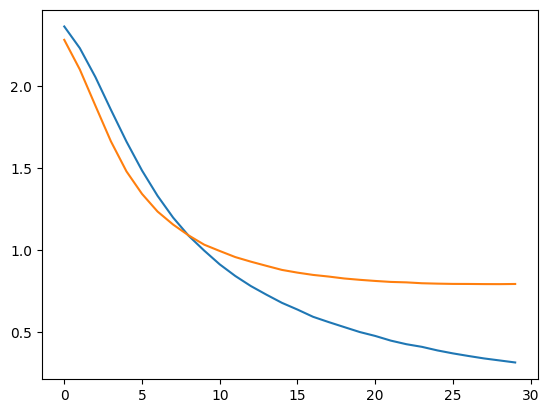

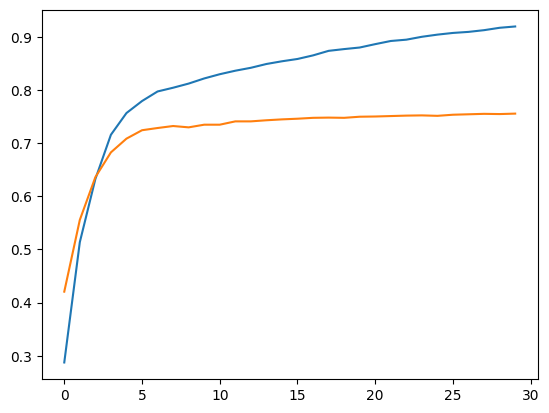

75/75 [==============================] - 0s 4ms/step


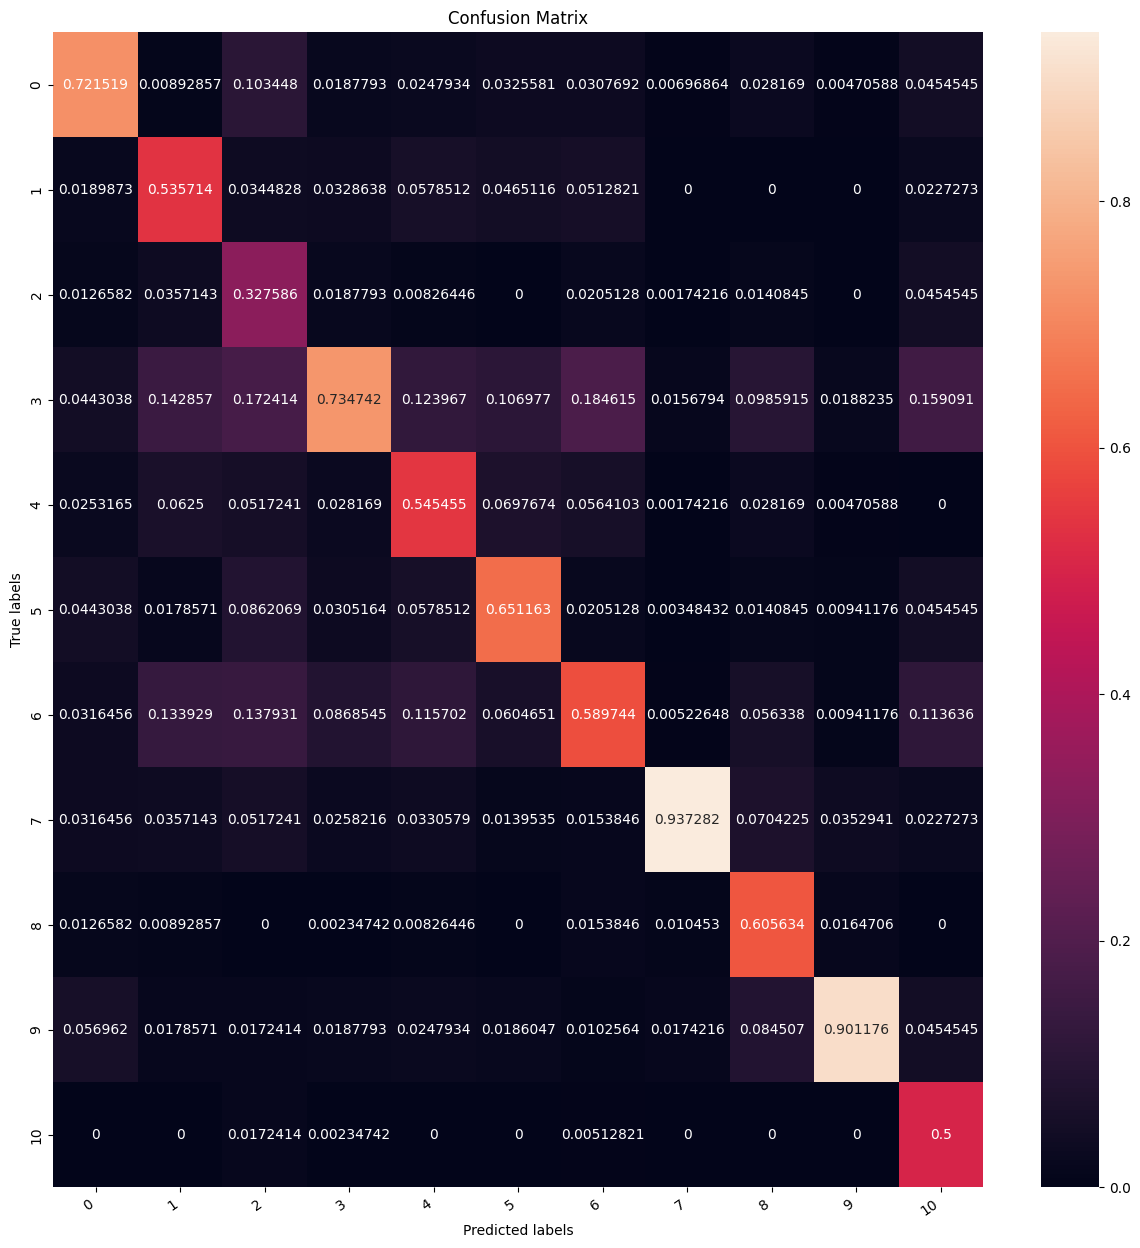

In [ ]:
  #11 classes
  import gc
  gc.collect()
  #классификатор однослойна нейросетка с l2 регуляризацией
  InputTrain=tfidf_NN.transform(XData_train[:,1]).toarray()
  InputTest=tfidf_NN.transform(XData_test[:,1]).toarray()
  InputTrainLabels=YData_train[:,0]
  InputTestLabels=YData_test[:,0]
  CategoryAmount=max(InputTrainLabels)+1
  WMS=         WeightsFromOneOut(np.sum(np.eye(CategoryAmount)[InputTrainLabels],axis=0))
  Model_11=Model1LDense(InputTrain.shape[1:],32,CategoryAmount,l2=0.000001, activation="relu")
  Model_11.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),metrics=[tf.keras.metrics.Precision(name='precision'),'accuracy'], loss="categorical_crossentropy")#categorical_crossentropy
  Model_11.summary()
  history1=Model_11.fit(InputTrain,np.eye(CategoryAmount)[InputTrainLabels],validation_data=[InputTest,np.eye(CategoryAmount)[InputTestLabels]],batch_size=256,class_weight=WMS, epochs=30,verbose=2)
  plt.plot(history1.history["loss"])
  plt.plot(history1.history["val_loss"])
  plt.show()
  plt.plot(history1.history['accuracy'])
  plt.plot(history1.history['val_accuracy'])
  plt.show()
  prd1=Model_11.predict(InputTest)
  PlotClassificationMatrix(prd1,np.eye(CategoryAmount)[InputTestLabels],figsize = (15,15))

In [ ]:
Model_11.save(FileDir+"Model_11.h5")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10000)]           0         
                                                                 
 dense_2 (Dense)             (None, 32)                320032    
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 27)                891       
                                                                 
Total params: 320923 (1.22 MB)
Trainable params: 320923 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/35
162/162 - 3s - loss: 3.2759 - precision: 0.0000e+00 - accuracy: 0.4331 - val_loss: 3.1719 - val_precision: 0.0000e+00 - val_accuracy: 0.6424 - 3

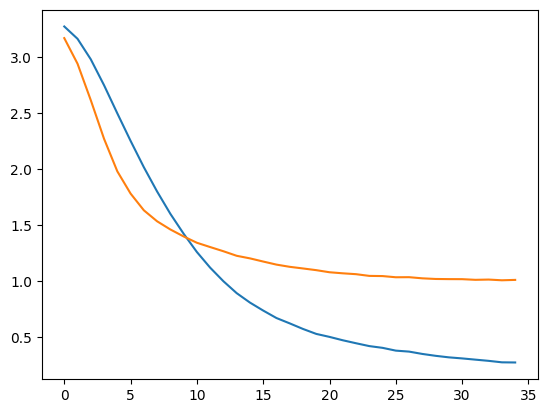

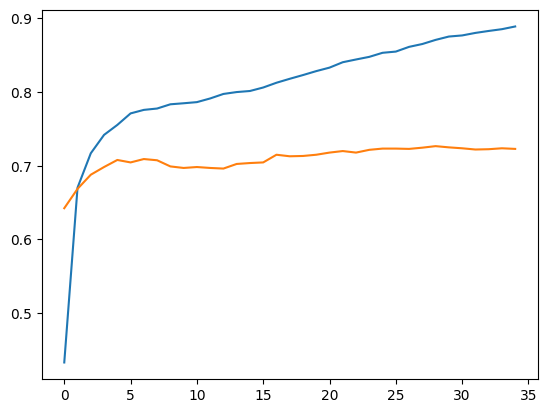

75/75 [==============================] - 0s 4ms/step


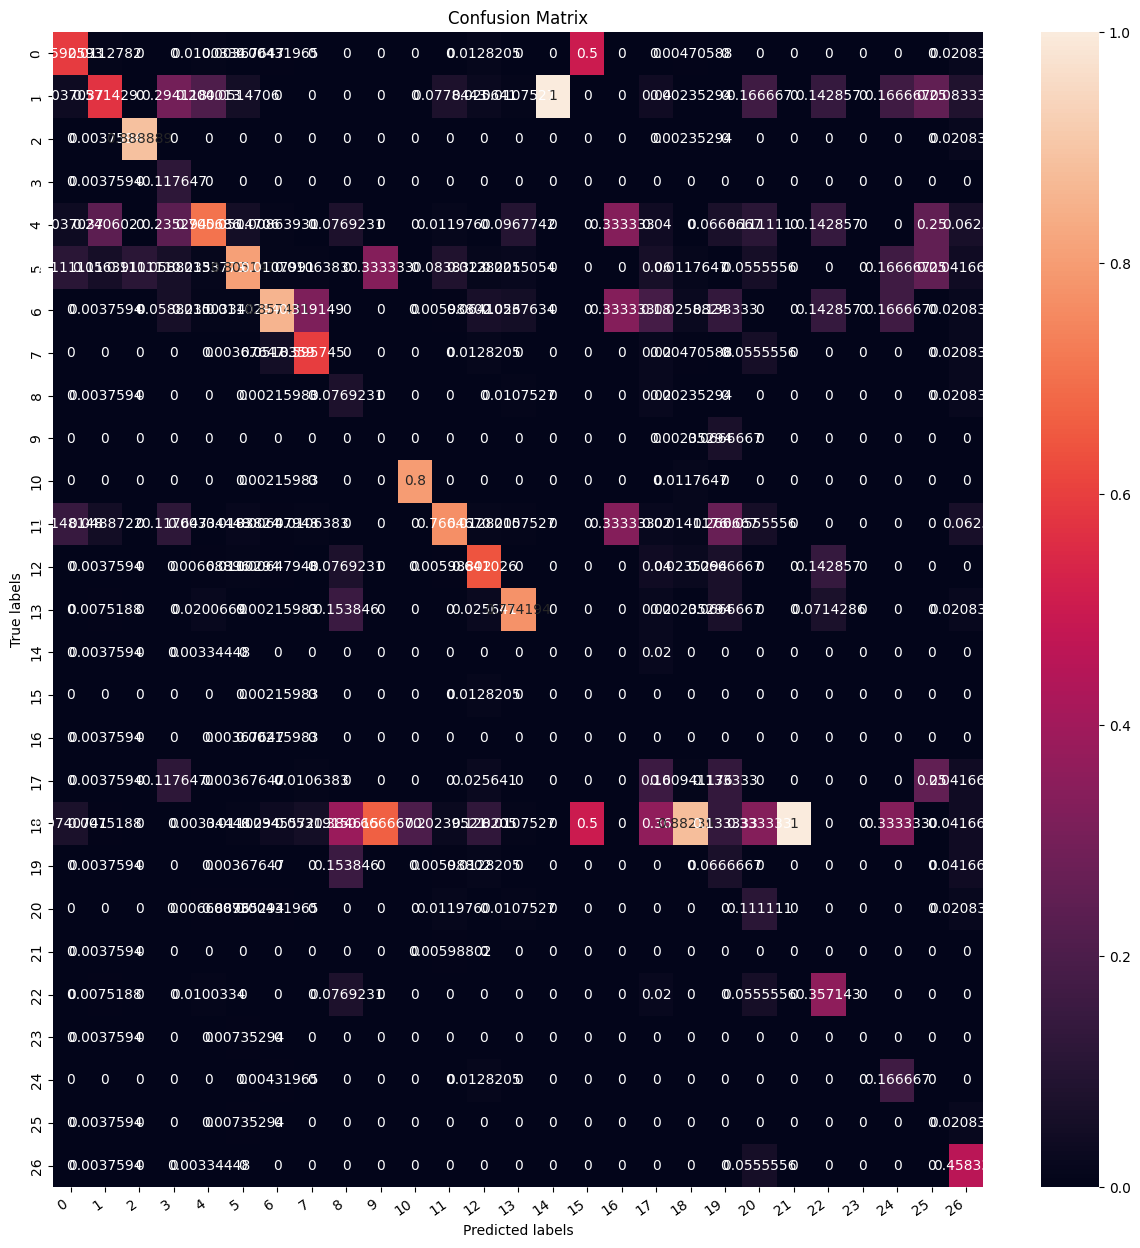

In [ ]:
  #27 classes
  #классификатор однослойна нейросетка с l2 регуляризацией
  InputTrain=tfidf_NN.transform(XData_train[:,1]).toarray()
  InputTest=tfidf_NN.transform(XData_test[:,1]).toarray()
  InputTrainLabels=YData_train[:,1]#.toarray()
  InputTestLabels=YData_test[:,1]#.toarray()
  CategoryAmount=max(InputTrainLabels)+1
  WMS=         WeightsFromOneOut(np.sum(np.eye(CategoryAmount)[InputTrainLabels],axis=0))
  Model_27=Model1LDense(InputTrain.shape[1:],32,CategoryAmount,l2=0.000005, activation="relu")
  Model_27.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),metrics=[tf.keras.metrics.Precision(name='precision'),'accuracy'], loss="categorical_crossentropy")#categorical_crossentropy
  Model_27.summary()
  history1=Model_27.fit(InputTrain,np.eye(CategoryAmount)[InputTrainLabels],validation_data=[InputTest,np.eye(CategoryAmount)[InputTestLabels]],batch_size=128,class_weight=WMS, epochs=35,verbose=2)
  plt.plot(history1.history["loss"])
  plt.plot(history1.history["val_loss"])
  plt.show()
  plt.plot(history1.history['accuracy'])
  plt.plot(history1.history['val_accuracy'])
  plt.show()
  prd1=Model_27.predict(InputTest)
  PlotClassificationMatrix(prd1,np.eye(CategoryAmount)[InputTestLabels],figsize = (15,15))

In [ ]:
Model_27.save(FileDir+"Model_27.h5")

#Тренировка моделей для конечного класса

In [ ]:
import keras
import random
from keras import regularizers
from keras import layers
from keras.models import load_model
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import accuracy_score
import tensorflow as tf

ImportError: ignored

In [ ]:
def Model1LDense(Shape1,Neurons,OutsClasses=3,l2=0, activation="relu"):
  inputs1 = keras.Input(shape=Shape1)
  x = layers.Dense(Neurons, activation=activation,kernel_regularizer=regularizers.l2(l2))(inputs1)
  x = layers.Dropout(0.1)(x)
  x = layers.Dense(OutsClasses, activation='softmax')(x)
  return keras.Model(inputs=inputs1, outputs=x)
def Model1LDense2(Shape1,Neurons,Neurons1,OutsClasses=3,l2=0, activation="relu"):
  inputs1 = keras.Input(shape=Shape1)
  x = layers.Dense(Neurons, activation=activation,kernel_regularizer=regularizers.l2(l2))(inputs1)
  x = layers.Dropout(0.1)(x)
  x = layers.Dense(Neurons1, activation=activation,kernel_regularizer=regularizers.l2(l2))(x)
  x = layers.Dense(OutsClasses, activation='softmax')(x)
  return keras.Model(inputs=inputs1, outputs=x)

In [ ]:
#Векторайзеры TFIDF для нейросети и дл модели на центроидах два разных варианта
tfidf_Centroid = TfidfVectorizer(max_features=100000, lowercase=True,ngram_range=(1, 5))
tfidf_Centroid = tfidf_Centroid.fit(XData[:,1])
tfidf_NN = TfidfVectorizer(max_features=10000, lowercase=True,ngram_range=(1, 2))
tfidf_NN = tfidf_NN.fit(XData[:,1])
#Сохарняем в файл для загрузке в классе
with open(FileDir+"TFIDF_Vectorizers.pkl","wb") as f:
  pickle.dump([tfidf_Centroid,tfidf_NN],f)

In [ ]:
# классификатор на центроидах для поля Тема 195 классов
clf = NearestCentroid()
clf.fit(tfidf_Centroid.transform(XData[:,1]),YData[:,2])
print(accuracy_score(YData_test[:,2],clf.predict(tfidf_Centroid.transform(XData_test[:,1]))))

0.7094622759483118


In [ ]:
#Запись в файл
with open(FileDir+"Cif.pkl","wb") as f:
  pickle.dump(clf,f)

In [ ]:
#Load check
with open(FileDir+"Cif.pkl","rb") as f:
  clf=pickle.load(f)
print(accuracy_score(YData_test[:,2],clf.predict(tfidf_Centroid.transform(XData_test[:,1]))))

In [ ]:
  #11 classes
  import gc
  gc.collect()
  #классификатор однослойна нейросетка с l2 регуляризацией
  InputTrain=tfidf_NN.transform(XData[:,1]).toarray()#tfidf_NN.transform(XData_train[:,1]).toarray()
  #InputTrain=tfidf_NN.transform(XData_train[:,1]).toarray()
  InputTest=tfidf_NN.transform(XData_test[:,1]).toarray()
  InputTrainLabels=YData[:,0]#YData_train[:,0]#.toarray()
  #InputTrainLabels=YData_train[:,0]#.toarray()
  InputTestLabels=YData_test[:,0]#.toarray()
  CategoryAmount=max(InputTrainLabels)+1
  WMS=         WeightsFromOneOut(np.sum(np.eye(CategoryAmount)[InputTrainLabels],axis=0))
  Model_11=Model1LDense(InputTrain.shape[1:],32,CategoryAmount,l2=0.000001, activation="relu")
  Model_11.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),metrics=[tf.keras.metrics.Precision(name='precision'),'accuracy'], loss="categorical_crossentropy")#categorical_crossentropy
  Model_11.summary()
  history1=Model_11.fit(InputTrain,np.eye(CategoryAmount)[InputTrainLabels],validation_data=[InputTest,np.eye(CategoryAmount)[InputTestLabels]],batch_size=256,class_weight=WMS, epochs=30,verbose=2)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10000)]           0         
                                                                 
 dense_4 (Dense)             (None, 32)                320032    
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 11)                363       
                                                                 
Total params: 320395 (1.22 MB)
Trainable params: 320395 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
91/91 - 4s - loss: 2.3606 - precision: 0.0000e+00 - accuracy: 0.4328 - val_loss: 2.2594 - val_precision: 0.0000e+00 - val_accuracy: 0.6365 - 4s/

In [ ]:
Model_11.save(FileDir+"Model_11.h5")

In [ ]:
  #27 classes
  #классификатор однослойна нейросетка с l2 регуляризацией
  InputTrain=tfidf_NN.transform(XData[:,1]).toarray()
  InputTest=tfidf_NN.transform(XData_test[:,1]).toarray()
  InputTrainLabels=YData[:,1]#.toarray()
  InputTestLabels=YData_test[:,1]#.toarray()
  CategoryAmount=max(InputTrainLabels)+1
  WMS=         WeightsFromOneOut(np.sum(np.eye(CategoryAmount)[InputTrainLabels],axis=0))
  Model_27=Model1LDense(InputTrain.shape[1:],32,CategoryAmount,l2=0.000005, activation="relu")
  Model_27.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),metrics=[tf.keras.metrics.Precision(name='precision'),'accuracy'], loss="categorical_crossentropy")#categorical_crossentropy
  Model_27.summary()
  history1=Model_27.fit(InputTrain,np.eye(CategoryAmount)[InputTrainLabels],validation_data=[InputTest,np.eye(CategoryAmount)[InputTestLabels]],batch_size=128,class_weight=WMS, epochs=35,verbose=2)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 10000)]           0         
                                                                 
 dense_6 (Dense)             (None, 32)                320032    
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 27)                891       
                                                                 
Total params: 320923 (1.22 MB)
Trainable params: 320923 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/35
181/181 - 3s - loss: 3.2752 - precision: 0.0000e+00 - accuracy: 0.4390 - val_loss: 3.1466 - val_precision: 0.0000e+00 - val_accuracy: 0.7061 - 3

In [ ]:
Model_27.save(FileDir+"Model_27.h5")

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


#Текст блок